In [30]:
import cv2
from PIL import Image
from tqdm import tqdm
import numpy as np
from create_video import search_face

In [31]:
cascade = cv2.CascadeClassifier(r'data/haarcascade.xml')

In [52]:
def best_frame(video_path, cascade):
    video = cv2.VideoCapture(video_path)

    while True:     
        ret, frame = video.read()

        faces = cascade.detectMultiScale(
            frame,
            scaleFactor=1.2,
            minNeighbors=6
        )

        if len(faces) == 0:
            continue

        max_area_face = faces[0]

        for face in faces:
            if face[2] > max_area_face[2]:
                max_area_face = face
        
        return max_area_face

In [56]:
video = cv2.VideoCapture('data/1.mp4')
ret, frame = video.read()
ret

True

In [53]:
face = best_frame('data/1.mp4', cascade)
face

array([645, 328, 444, 444], dtype=int32)

In [63]:
tuple(face)

(645, 328, 444, 444)

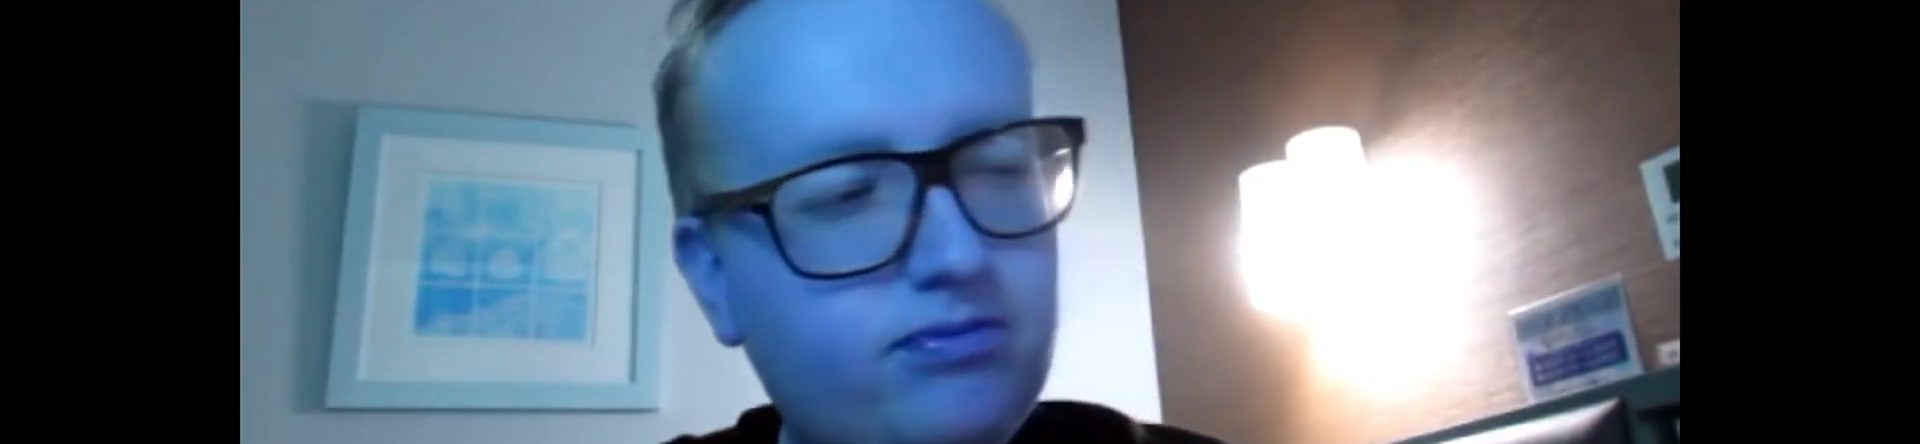

In [64]:
Image.fromarray(frame[328:328 + 444])

In [65]:
frame.shape

(1080, 1920, 3)

In [45]:
type(faces)

tuple

In [46]:
isinstance(faces, tuple)

True

In [40]:
faces = cascade.detectMultiScale(
        frame,
        scaleFactor=1.2,
        minNeighbors=6
    )

In [41]:
faces

()

In [29]:
bool((5, 20, 1))

True

In [15]:
ret, frame = video.read()
ret
face = search_face(frame, cascade, coord=True)

In [16]:
face

False